# Predicting Speed Dating Outcomes: Classification Model Evaluation

## Overview

In this notebook we conduct exploratory data analysis to narrow down and clean features for prediction via machine learning.

The data we work with represents four minute dates between individuals during speed dating events between the years of 2002 and 2004. A total of twenty-two waves were held and participants filled out surveys before, during, and after their dates.

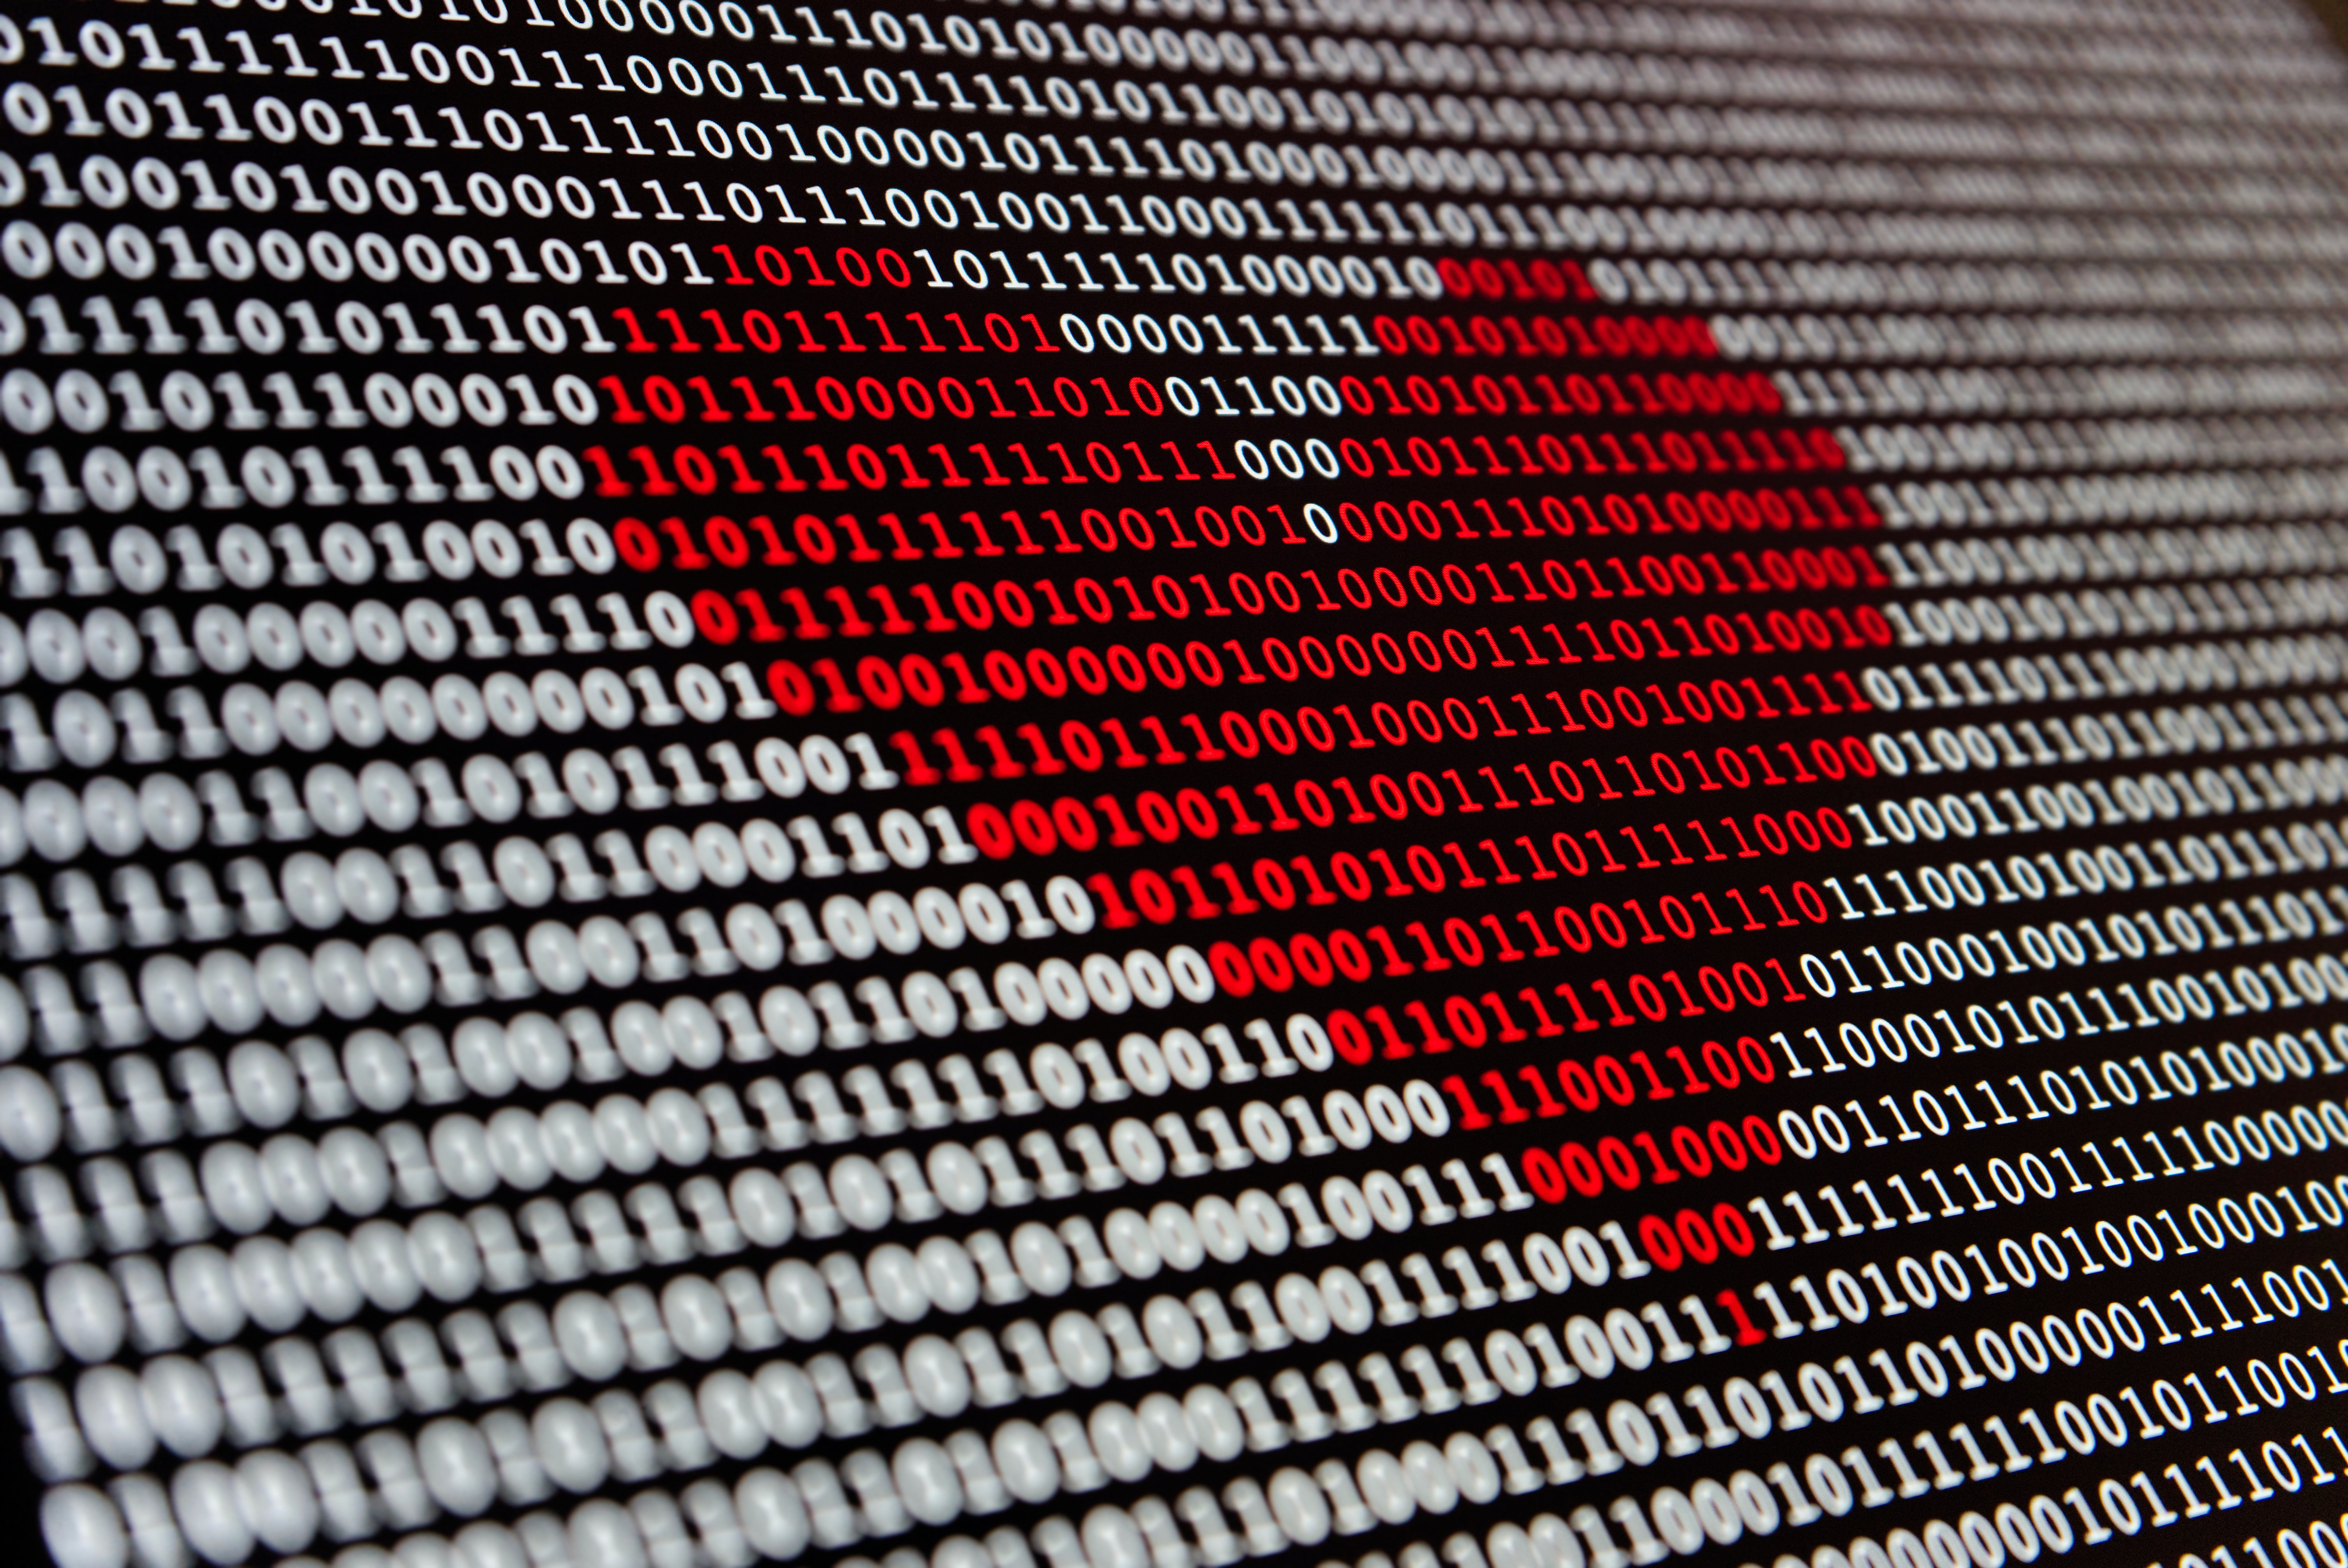

<center>
    Image by
    <a href = https://unsplash.com/@swimstaralex>Alexander Sinn</a>
    from
    <a href = https://unsplash.com>Unsplash</a>
</center>

## Data Structure

- Data can be found in the /data folder. Obtained from [Kaggle.com](https://www.kaggle.com/annavictoria/speed-dating-experiment)
- All images can be found in the /images folder.
- [Business Insights Presentation](https://docs.google.com/presentation/d/1D584urKrCWcNV2nkgPIlVxCe3ZPuJ7dHYZYQXkUSxmQ/edit?usp=sharing)

Contributors:
- [Isana Mizuma](https://github.com/ismizu)
- [Tyrell Jackson](https://github.com/Tyronious25)

## Primary Focus

Our primary focus is to:
1. Clean our data into a useable format
2. Compare/contrast models to narrow down the best choice

<h1 align = 'center'> Exploratory Data Analysis </h1>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,\
accuracy_score, f1_score, recall_score, precision_score, plot_roc_curve

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 110)

## Initial Read In

In [2]:
df = pd.read_csv('../data/speed_dating_data.csv')

First, we define our target as the column "dec" which indicates whether the individual taking the survey decided they would or would not like a date with the individual. As such, we drop "dec_o", their partners decision, and "match" which states whether both individuals said yes or not.  

With this, we also note that our investigation is into predicting what factors make the individual express that initial interest. As such, we remove columns regarding post or during date information.

## Data Cleaning

In [3]:
#Select only columns with information prior and during speed date
df_clean = df.loc[:,'iid':'match_es']

#Drop column contain individual dating decision
df_clean.drop(columns = ['dec_o', 'match'], inplace = True)

One of the first things we look into are NaN values within individual surveys. This survey was for individuals to rank the following attributes: physical attraction, sincerity, intelligence, fun, ambition, and shared interests. They rated them based on what they were looking for, what they thought others were looking for, how they thought they themselves rated, as well as how others might rate them.

In filling the NaN values, we decid to impute the mean as our models had the greatest success with that method.

We also drop columns attr5_1 through amb5_1 due to a near 50% NaN count for those columns.

In [4]:
#List of survey columns
columns = df_clean.loc[:,'attr1_1':'amb5_1'].columns.tolist()

df_clean[columns].isna().sum()

attr1_1       79
sinc1_1       79
intel1_1      79
fun1_1        89
amb1_1        99
shar1_1      121
attr4_1     1889
sinc4_1     1889
intel4_1    1889
fun4_1      1889
amb4_1      1889
shar4_1     1911
attr2_1       79
sinc2_1       79
intel2_1      79
fun2_1        79
amb2_1        89
shar2_1       89
attr3_1      105
sinc3_1      105
fun3_1       105
intel3_1     105
amb3_1       105
attr5_1     3472
sinc5_1     3472
intel5_1    3472
fun5_1      3472
amb5_1      3472
dtype: int64

In [5]:
#Fill NaN values in survey columns with mean results
for col in columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

#Drop attr5_1 through amb5_1
df_clean.drop(columns = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1'], inplace = True)

Our model showed the greatest success with this method.

However, we supply the code for other methods.

Feel free to uncomment and run the code below to test their later effect in the model.

In [6]:
#----- Uncomment and run the code below to undo the effects of the previous cell -----#
#df_clean = df.loc[:,'iid':'match_es']
#df_clean.drop(columns = ['dec_o', 'match'], inplace = True)


#----- Fill NaN values with zero -----#
#for col in columns:
#    df_clean[col] = df_clean[col].fillna(0)


#----- Drop NaN values -----#
#df.drop(columns = columns, inplace = True)


#----- Remove rows with NaN values -----#
#Do not run this cell or the code cell above
#NaN values will be dropped as final data cleaning later on

With the NaN values contained within the surveys handled, we also take at look at columns 'age_o' through 'prob_o' which indicate what the individual's partner felt about the individual. As with the above, we found the greatest success when imputing the mean.

We also supply variations to the code that can be run in place of imputing the mean to test their effects.

In [7]:
#List of partner ratings
partner_columns = df_clean.loc[:,'age_o':'prob_o'].columns.tolist()

In [8]:
#Replacing NaN values with column mean
for col in partner_columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())


#----- Fill NaN values with zero -----#
#for col in partner_columns:
#    df_clean[col] = df_clean[col].fillna(0)


#----- Drop NaN values -----#
#df.drop(columns = partner_columns, inplace = True)


#----- Remove rows with NaN values -----#
#Do not run this cell
#NaN values will be dropped as final data cleaning later on

The following completes our data cleaning and includes: dropping due to majority missing data, dummying categorical data, as well as minor NaN value filling.

In [9]:
#Drop exp num due to large majority NaN values
df_clean.drop(columns = 'expnum', inplace = True)

#Dummy met column
df_clean['met'] = np.where(df_clean['met'] == 2 , 1, 0)
df_clean['met_o'] = np.where(df_clean['met_o'] == 2 , 1, 0)

#Fill match_es (believed number of matches) NaN's as 0
df_clean['match_es'] =  df_clean['match_es'].fillna(0)

#Drop mid-date columns
df_clean.drop(columns = df.loc[:,'attr':'prob'].columns.tolist(), inplace = True)


#Drop additional columns containing the following:
    #Large number of NaN values or dependence on those columns
    #Positional data for day of date
    #Columns later dummied in original data
    #No bearing on model
df_clean.drop(columns = ['iid', 'id', 'idg', 'wave', 'position', 'positin1', 'partner', 'pid',
                         'field', 'mn_sat', 'tuition', 'income', 'undergra', 'condtn', 'gender',
                         'zipcode', 'career', 'from', 'round', 'order', 'career_c'], inplace = True)

#Reassign dec as first column
first_column = df_clean.pop('dec')
df_clean.insert(0, 'dec', first_column)

#Drop remaining NaN values
df_clean.dropna(inplace = True)

#Reset index
#df_clean.reset_index(drop = True, inplace = True)

<h1 align = 'center'> Modeling Process </h1>

Having completed our data cleaning, we begin some preliminary modeling. Primarily, a base logistic regression model to serve as our base. The first step is to investigate feature correlation with our target 'dec'

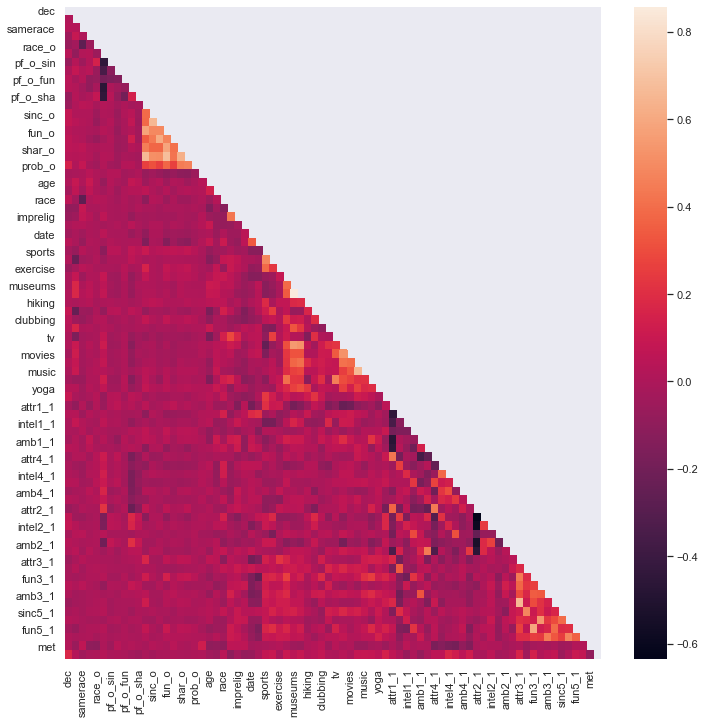

In [10]:
sns.set(rc={'figure.figsize':(12, 12)})

corr = df_clean.corr()

#Remove the upper right half of the matrix, a duplicate of the lower left half
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#Graph the correlation matrix
sns.heatmap(corr, mask = mask);

With the color gradient, we see some correlation between values.

As such, we take a closer look.

In [11]:
df_clean.loc[:,'sinc_o':'prob_o'].corr()

sinc_o   intel_o     fun_o     amb_o    shar_o    like_o    prob_o
sinc_o   1.000000  0.656138  0.484707  0.443116  0.376551  0.513119  0.315230
intel_o  0.656138  1.000000  0.485564  0.609302  0.376286  0.502806  0.259597
fun_o    0.484707  0.485564  1.000000  0.472085  0.588174  0.679574  0.374450
amb_o    0.443116  0.609302  0.472085  1.000000  0.409765  0.425434  0.266127
shar_o   0.376551  0.376286  0.588174  0.409765  1.000000  0.625060  0.444830
like_o   0.513119  0.502806  0.679574  0.425434  0.625060  1.000000  0.462378
prob_o   0.315230  0.259597  0.374450  0.266127  0.444830  0.462378  1.000000

Looking through this table, there are no values that cross a threshold we set at .7 for multicollinearity.

And so, we retain all variables and look into the aspect that most concerned us. Looking at correlations with dec, our target, from the graph alone there does not appear to be any strongly correlated values.

In fact, when we look at the numbers themselves:

In [12]:
df_clean.corr()['dec']

dec         1.000000
int_corr    0.016946
samerace    0.025534
age_o      -0.050101
race_o     -0.069288
pf_o_att    0.038166
pf_o_sin   -0.070443
pf_o_int    0.004183
pf_o_fun    0.043185
pf_o_amb    0.037743
pf_o_sha   -0.080579
attr_o     -0.062134
sinc_o      0.079677
intel_o     0.079692
fun_o       0.041315
amb_o       0.061432
shar_o      0.053662
like_o      0.037393
prob_o      0.149904
met_o      -0.016506
age         0.012201
field_cd   -0.031189
race        0.053950
imprace    -0.089867
imprelig   -0.068665
goal       -0.002027
date       -0.036414
go_out      0.041388
sports     -0.025790
tvsports    0.014952
exercise   -0.067150
dining     -0.001603
museums    -0.002655
art         0.012864
hiking      0.012154
gaming      0.084235
clubbing    0.043793
reading     0.033871
tv          0.002490
theater     0.011096
movies     -0.026597
concerts    0.022762
music      -0.000702
shopping   -0.030189
yoga        0.034228
exphappy    0.089077
attr1_1    -0.023796
sinc1_1     0

Looking through these columns, we find that an individual's expectation of how many matches they will have (match_es) holds the high correlation with our target variable, dec. However, at .17, we are unable to state that it even has a correlation as we set a threshold of .3 for minimum correlation.

The remaining data columns contain information post or during the date, which would go against our desire to predict individual attraction pre-date.

With the outcome of the correlation investigation, we created a base model to see if we can get any additional insights from it.

The metric we are scoring by is accuracy. This would be how often the model correctly identified a zero or one. Or in other words:
- How well does our model correctly identify whether someone says yes or no to a date?

In [13]:
#Create a dataframe to save/view our results
base_model_results = pd.DataFrame(columns = ['name',
                                             'accuracy_train', 'accuracy_test',
                                             'recall_train', 'recall_test',
                                             'precision_train', 'precision_test',
                                             'f1_score_train', 'f1_score_test'])

#Function to write scores to dataframe
def base_add_score(name, y_train, train_pred, y_test, test_pred):

    train_acc = round(accuracy_score(y_train, train_pred), 2)
    train_recall = round(recall_score(y_train, train_pred), 2)
    train_precision = round(precision_score(y_train, train_pred), 2)
    train_f1 = round(f1_score(y_train, train_pred), 2)

    test_acc = round(accuracy_score(y_test, test_pred), 2)
    test_recall = round(recall_score(y_test, test_pred), 2)
    test_precision = round(precision_score(y_test, test_pred), 2)
    test_f1 = round(f1_score(y_test, test_pred), 2)
    
    global base_model_results
    
    base_model_results = base_model_results.append({'name': name,
                                                    'accuracy_train': train_acc,
                                                    'accuracy_test': test_acc,
                                                    'recall_train': train_recall,
                                                    'recall_test': test_recall,
                                                    'precision_train': train_precision,
                                                    'precision_test': test_precision,
                                                    'f1_score_train': train_f1,
                                                    'f1_score_test': test_f1},
                                                   ignore_index = True)

In [14]:
#Train test split our data
y = df_clean['dec']
X = df_clean.drop(columns = ['dec'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42)

#Instantiate the pipeline for our LogisticRegression model
log_reg_pipe = Pipeline([
        ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state = 42,
                                  class_weight = 'balanced'))
])

#Fit our data to the pipeline
log_reg_pipe.fit(X_train, y_train)

#Save predictions and add them to our dataframe
train_pred_base = log_reg_pipe.predict(X_train)
test_pred_base = log_reg_pipe.predict(X_test)

base_add_score('base_logistic_regression', y_train, train_pred_base, y_test, test_pred_base)
base_model_results

name  accuracy_train  accuracy_test  recall_train  \
0  base_logistic_regression            0.66           0.64          0.66   

   recall_test  precision_train  precision_test  f1_score_train  f1_score_test  
0         0.64             0.59            0.57            0.62            0.6

Our base model shows a 64% accuracy in predicting that an individual would want to date another. 

This means that our model can only correctly identify an individual's interest in dating 64% of the time.

With this score, and the low correlation of our features with the target variable, we take a look at the confusion matrix

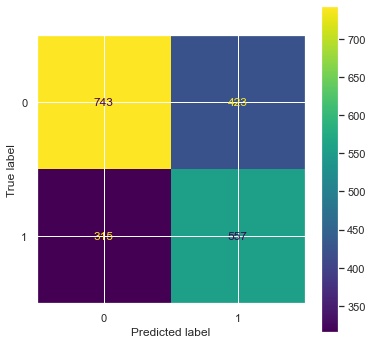

In [15]:
sns.set(rc={'figure.figsize':(6, 6)})
plot_confusion_matrix(log_reg_pipe, X_test, y_test);

The model incorrectly predicted 423 0's out of 1166. It also incorrectly predicted 315 1's out of 872.

In fact, despite many iterations, we were unable to achieve at least a 75% accuracy score. 

We were able to receive higher scores with the inclusion of data during the date, but the prediction we are searching for is to dating preference _before_ the individuals date.

Due to this low score, as well as the low correlation between values, we decide to test additional models to view their outcome.

In our investigation of this, we test several different models, KNearestNeighbor, DecisionTree, and RandomForest. We then add them to our dataframe to view their results.

Note: Running the following cells may take some time depending on the computer, due to the Grid Search

In [16]:
#Instantiate the pipeline
knn_pipe = Pipeline([
        ('std_scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())])

#Define the parameters we wish GridSearch to test
kn_grid = {'knn__n_neighbors': list(range(20, 31, 2)),
           'knn__metric': ['minkowski', 'manhattan'],
           'knn__weights': ['uniform', 'distance']
}

#Instantiate GridSearchCV and fit to our data
gs = GridSearchCV(knn_pipe, param_grid = kn_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')
gs.fit(X_train, y_train)

#Add the results to our dataframe
y_train_pred_knn = gs.best_estimator_.predict(X_train)
y_test_pred_knn = gs.best_estimator_.predict(X_test)
base_add_score('KNearestNeighbor', y_train, y_train_pred_knn, y_test, y_test_pred_knn)

#View the best hyperparameters found by GridSearch CV
gs.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 30,
 'knn__weights': 'distance'}

In [17]:
#Instantiate the pipeline
dtc_pipe = Pipeline([
        ('std_scaler', StandardScaler()),
        ('dtc', DecisionTreeClassifier(class_weight = 'balanced',
                                       random_state = 42))])

#Define the parameters we wish GridSearch to test
dtc_grid = {'dtc__max_depth': list(range(0, 40, 10)),
           'dtc__min_samples_leaf': list(range(0, 15, 5)),
           'dtc__max_leaf_nodes': list(range(0, 101, 10))
}

#Instantiate GridSearchCV and fit to our data
dtc_gs = GridSearchCV(dtc_pipe, param_grid = dtc_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')
dtc_gs.fit(X_train, y_train)

#Add the results to our dataframe
y_train_pred_dtc = dtc_gs.best_estimator_.predict(X_train)
y_test_pred_dtc = dtc_gs.best_estimator_.predict(X_test)
base_add_score('DecisionTreeClassifier', y_train, y_train_pred_dtc, y_test, y_test_pred_dtc)

#View the best hyperparameters found by GridSearch CV
dtc_gs.best_params_

{'dtc__max_depth': 10, 'dtc__max_leaf_nodes': 50, 'dtc__min_samples_leaf': 10}

In [18]:
#Instantiate the pipeline
rfr_pipe = Pipeline([
        ('std_scaler', StandardScaler()),
        ('rfr', RandomForestClassifier(n_estimators = 200,
                                       class_weight = 'balanced'))])

#Define the parameters we wish GridSearch to test
rfr_grid = {'rfr__max_depth': list(range(0, 31, 10)),
           'rfr__min_samples_leaf': list(range(0, 10, 2)),
           'rfr__max_leaf_nodes': list(range(200, 301, 10))}

#Instantiate GridSearchCV and fit to our data
rfr_gs = GridSearchCV(rfr_pipe, param_grid = rfr_grid, cv = 5, n_jobs = -1, verbose = 1, scoring = 'accuracy')
rfr_gs.fit(X_train, y_train)

#Add the results to our dataframe
y_train_pred_rfr = rfr_gs.best_estimator_.predict(X_train)
y_test_pred_rfr = rfr_gs.best_estimator_.predict(X_test)
base_add_score('RandomForestClassifier', y_train, y_train_pred_rfr, y_test, y_test_pred_rfr)

#View the best hyperparameters found by GridSearch CV
rfr_gs.best_params_

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


{'rfr__max_depth': 10, 'rfr__max_leaf_nodes': 220, 'rfr__min_samples_leaf': 8}

In [19]:
base_model_results

name  accuracy_train  accuracy_test  recall_train  \
0  base_logistic_regression            0.66           0.64          0.66   
1          KNearestNeighbor            1.00           0.68          1.00   
2    DecisionTreeClassifier            0.69           0.65          0.73   
3    RandomForestClassifier            0.85           0.69          0.83   

   recall_test  precision_train  precision_test  f1_score_train  f1_score_test  
0         0.64             0.59            0.57            0.62           0.60  
1         0.48             1.00            0.68            1.00           0.56  
2         0.64             0.61            0.58            0.66           0.61  
3         0.60             0.82            0.65            0.82           0.62

Looking at the scores, there is some improvement in scores. However, the models', particularly KNearestNeighbor, hyperparameters are causing quite a bit of overfitting. We will have to revisit both the parameters as well as the data to fix this issue.

However, we do note that the scores did not improve by much, leading us to believe that continued cleaning/tuning may not result in the .75 accuracy we are looking for. Running Random Forest with grid search resulted in a .70 accuracy, however the recall dropped quite a bit, showing that it was more accurate at predicting 0's, but fell in its predictions for 1's.
For our predictions, we are placing a heavier weight into predicting 1's, or yes', so this model may not be feasible as well.

At this point, we decided to take a look at how the date itself influences ones decision, rather than predictions based solely on pre-date factors.

# Modeling with Post Date Survey Data

First, we segment our original data into a dataframe containing only survey data obtained immediately after each speed date.

In [20]:
#Create dataframe with date information
date_df = df.loc[:,'attr':'prob']
#Insert dec into dataframe
first_column = df['dec']
date_df.insert(0, 'dec', first_column)

#List columns for mean imputing
na_columns = date_df.columns.tolist()
for col in na_columns:
    date_df[col] = date_df[col].fillna(round(date_df[col].mean(), 1))

#Check NaN values successfully imputed
assert sum(date_df.isna().sum()) == 0

In [21]:
date_df

dec  attr  sinc  intel  fun  amb  shar  like  prob
0       1   6.0   9.0    7.0  7.0  6.0   5.0   7.0   6.0
1       1   7.0   8.0    7.0  8.0  5.0   6.0   7.0   5.0
2       1   5.0   8.0    9.0  8.0  5.0   7.0   7.0   5.2
3       1   7.0   6.0    8.0  7.0  6.0   8.0   7.0   6.0
4       1   5.0   6.0    7.0  7.0  6.0   6.0   6.0   6.0
...   ...   ...   ...    ...  ...  ...   ...   ...   ...
8373    0   3.0   5.0    5.0  5.0  6.8   5.5   2.0   5.0
8374    0   4.0   6.0    8.0  4.0  4.0   5.5   4.0   4.0
8375    0   4.0   7.0    8.0  8.0  8.0   5.5   6.0   5.0
8376    0   4.0   6.0    5.0  4.0  6.8   5.0   5.0   5.0
8377    0   3.0   7.0    6.0  4.0  8.0   1.0   4.0   5.0

[8378 rows x 9 columns]

<p>
<p>Now having a dataframe to work with, we run our base model on it.
<p>

In [22]:
#Train test split our data
y_date = date_df['dec']
X_date = date_df.drop(columns = ['dec'])

X_date_train, X_date_test, y_date_train, y_date_test = train_test_split(X_date, y_date,
                                                                        random_state = 42)

#Fit our data to the base model's pipeline
log_reg_pipe.fit(X_date_train, y_date_train)

#Save predictions and add them to our dataframe
date_train_pred_base = log_reg_pipe.predict(X_date_train)
date_test_pred_base = log_reg_pipe.predict(X_date_test)

base_add_score('base_model_during_date', y_date_train,
               date_train_pred_base,y_date_test, date_test_pred_base)

#Only view base model scores
base_model_results[base_model_results['name'].str.contains('base')]

name  accuracy_train  accuracy_test  recall_train  \
0  base_logistic_regression            0.66           0.64          0.66   
4    base_model_during_date            0.77           0.75          0.78   

   recall_test  precision_train  precision_test  f1_score_train  f1_score_test  
0         0.64             0.59            0.57            0.62           0.60  
4         0.76             0.70            0.69            0.74           0.73

Using only the eight columns containing how the individual rated their partner during the four minute date, we were able to achieve exactly the .75 we were looking for.

As defined in our Business Case notebook, depending on gender, there were notable differences between what an individual stated they wanted, and what how they rated partners that they identified positively with. We can see this in the model predictions. Despite our best efforts, our accuracy remains quite low when only utilizing pre-date information.

Next, we test the model with with pre and post date information combined.

In [23]:
#Concat the two dataframes
concat_df = pd.concat([df_clean, date_df.loc[:,'attr':'prob']], axis = 1)
#Drop any resulting NaN's caused by count imbalance
concat_df.dropna(inplace = True)
concat_df

dec  int_corr  samerace  age_o  race_o  pf_o_att  pf_o_sin  pf_o_int  \
0     1.0      0.14       0.0   27.0     2.0      35.0      20.0      20.0   
1     1.0      0.54       0.0   22.0     2.0      60.0       0.0       0.0   
2     1.0      0.16       1.0   22.0     4.0      19.0      18.0      19.0   
3     1.0      0.61       0.0   23.0     2.0      30.0       5.0      15.0   
4     1.0      0.21       0.0   24.0     3.0      30.0      10.0      20.0   
...   ...       ...       ...    ...     ...       ...       ...       ...   
8373  0.0      0.64       0.0   26.0     3.0      10.0      10.0      30.0   
8374  0.0      0.71       0.0   24.0     6.0      50.0      20.0      10.0   
8375  0.0     -0.46       0.0   29.0     3.0      40.0      10.0      30.0   
8376  0.0      0.62       0.0   22.0     4.0      10.0      25.0      25.0   
8377  0.0      0.01       0.0   22.0     4.0      20.0      20.0      10.0   

      pf_o_fun  pf_o_amb  pf_o_sha  attr_o  sinc_o  intel_o  fun_o  amb_o  \
0         20.0       0.0   5.00000     6.0     8.0      8.0    8.0    8.0   
1         40.0       0.0   0.00000     7.0     8.0     10.0    7.0    7.0   
2         18.0      14.0  12.00000    10.0    10.0     10.0   10.0   10.0   
3         40.0       5.0   5.00000     7.0     8.0      9.0    8.0    9.0   
4         10.0      10.0  20.00000     8.0     7.0      9.0    6.0    9.0   
...        ...       ...       ...     ...     ...      ...    ...    ...   
8373      20.0      10.0  15.00000    10.0     5.0      3.0    2.0    6.0   
8374       5.0      10.0   5.00000     6.0     3.0      7.0    3.0    7.0   
8375      10.0      10.0  11.84593     2.0     1.0      2.0    2.0    2.0   
8376      10.0      10.0  20.00000     5.0     7.0      5.0    5.0    3.0   
8377      15.0       5.0  30.00000     8.0     8.0      7.0    7.0    7.0   

      shar_o  like_o  prob_o  met_o   age  field_cd  race  imprace  imprelig  \
0        6.0     7.0     4.0    1.0  21.0       1.0   4.0      2.0       4.0   
1        5.0     8.0     4.0    1.0  21.0       1.0   4.0      2.0       4.0   
2       10.0    10.0    10.0    0.0  21.0       1.0   4.0      2.0       4.0   
3        8.0     7.0     7.0    1.0  21.0       1.0   4.0      2.0       4.0   
4        7.0     8.0     6.0    1.0  21.0       1.0   4.0      2.0       4.0   
...      ...     ...     ...    ...   ...       ...   ...      ...       ...   
8373     5.0     6.0     1.0    0.0  25.0      18.0   2.0      1.0       1.0   
8374     2.0     2.0     2.0    1.0  25.0      18.0   2.0      1.0       1.0   
8375     1.0     2.0     1.0    1.0  25.0      18.0   2.0      1.0       1.0   
8376     6.0     6.0     4.0    1.0  25.0      18.0   2.0      1.0       1.0   
8377     7.0     8.0     5.0    1.0  25.0      18.0   2.0      1.0       1.0   

      goal  date  go_out  sports  tvsports  exercise  dining  museums   art  \
0      2.0   7.0     1.0     9.0       2.0       8.0     9.0      1.0   1.0   
1      2.0   7.0     1.0     9.0       2.0       8.0     9.0      1.0   1.0   
2      2.0   7.0     1.0     9.0       2.0       8.0     9.0      1.0   1.0   
3      2.0   7.0     1.0     9.0       2.0       8.0     9.0      1.0   1.0   
4      2.0   7.0     1.0     9.0       2.0       8.0     9.0      1.0   1.0   
...    ...   ...     ...     ...       ...       ...     ...      ...   ...   
8373   1.0   2.0     1.0     8.0       2.0       5.0    10.0     10.0  10.0   
8374   1.0   2.0     1.0     8.0       2.0       5.0    10.0     10.0  10.0   
8375   1.0   2.0     1.0     8.0       2.0       5.0    10.0     10.0  10.0   
8376   1.0   2.0     1.0     8.0       2.0       5.0    10.0     10.0  10.0   
8377   1.0   2.0     1.0     8.0       2.0       5.0    10.0     10.0  10.0   

      hiking  gaming  clubbing  reading   tv  theater  movies  concerts  \
0        5.0     1.0       5.0      6.0  9.0      1.0    10.0      10.0   
1        5.0     1.0       5.0      6.0  9.0      1.0    10.0      10.0   
2        

In [24]:
#Train test split our data
y_concat = concat_df['dec']
X_concat = concat_df.drop(columns = ['dec'])

X_concat_train, X_concat_test, y_concat_train, y_concat_test = train_test_split(X_concat, y_concat,
                                                                                random_state = 42)

#Fit our data to the base model's pipeline
log_reg_pipe.fit(X_concat_train, y_concat_train)

#Save predictions and add them to our dataframe
concat_train_pred_base = log_reg_pipe.predict(X_concat_train)
concat_test_pred_base = log_reg_pipe.predict(X_concat_test)

base_add_score('base_model_pre_and_during_date', y_concat_train,
               concat_train_pred_base,y_concat_test, concat_test_pred_base)

#Only view base model scores
base_model_results[base_model_results['name'].str.contains('base')]

name  accuracy_train  accuracy_test  \
0        base_logistic_regression            0.66           0.64   
4          base_model_during_date            0.77           0.75   
5  base_model_pre_and_during_date            0.80           0.79   

   recall_train  recall_test  precision_train  precision_test  f1_score_train  \
0          0.66         0.64             0.59            0.57            0.62   
4          0.78         0.76             0.70            0.69            0.74   
5          0.81         0.78             0.74            0.74            0.77   

   f1_score_test  
0           0.60  
4           0.73  
5           0.76

By bringing both pre-date and during-date data, we receive a remarkably higher score compared to our efforts with simply pre-date information.

With this, we realize that what is most important in bringing the two individuals together in the first place. Due to stark differences in what an individual believes they want compared to how they view those same traits during the date, a pre-date prediction performs minimally better than flipping a coin.

While our pre-date predictions might help narrow down choices by a small amount, what is most important is getting the individuals interacting, whether that may be through physically meeting or initiating conversation is a different matter.

Knowing this, we take one more look at the data. This time, we explore the effect of physical attraction as our investigation into various insights showed this mattered greatly, regardless of whether the individual rated it as important or not.

# Physical Attraction based Prediction

To complete this, we create a new dataframe. One containing only two columns, our target, dec, as well as attr, or how physically attractive the individual found their partner.

Following this, we run our base model on the attr feature alone.

In [25]:
#Create the dataframe & drop NaN's
attr_df = df[['dec', 'attr']]
attr_df.dropna(inplace = True) #202 NaN's out of 8378 observations

#Train test split
y_attr = attr_df['dec']
X_attr = attr_df[['attr']]

X_attr_train, X_attr_test, y_attr_train, y_attr_test = train_test_split(X_attr, y_attr,
                                                                        random_state = 42)

#Fit the dataframe to our base model
log_reg_pipe.fit(X_attr_train, y_attr_train)

#Save predictions and add them to the results dataframe
attr_train_pred = log_reg_pipe.predict(X_attr_train)
attr_test_pred = log_reg_pipe.predict(X_attr_test)

base_add_score('base_model_attr', y_attr_train,
               attr_train_pred,y_attr_test, attr_test_pred)

#Only view base model scores
base_model_results[base_model_results['name'].str.contains('base')]

name  accuracy_train  accuracy_test  \
0        base_logistic_regression            0.66           0.64   
4          base_model_during_date            0.77           0.75   
5  base_model_pre_and_during_date            0.80           0.79   
6                 base_model_attr            0.73           0.73   

   recall_train  recall_test  precision_train  precision_test  f1_score_train  \
0          0.66         0.64             0.59            0.57            0.62   
4          0.78         0.76             0.70            0.69            0.74   
5          0.81         0.78             0.74            0.74            0.77   
6          0.71         0.75             0.67            0.67            0.69   

   f1_score_test  
0           0.60  
4           0.73  
5           0.76  
6           0.70

Using only the physical attraction that the individual felt, we are able to get very close to our prediction based on all during-date attribute ratings and we are not too far off from our both_dataframes_base_model.

As such, we come to the conclusion that one of the most important aspects to engaging with another individual is perceived physical attraction.

Blind dating applications where individuals cannot see each other before engaging may be met with limited success as a result. What is most important is that individuals have the chance to view each other through profile pictures, galleries, etc and have the chance to judge their physical attraction to each other.